<div style="margin-bottom: 32px;">
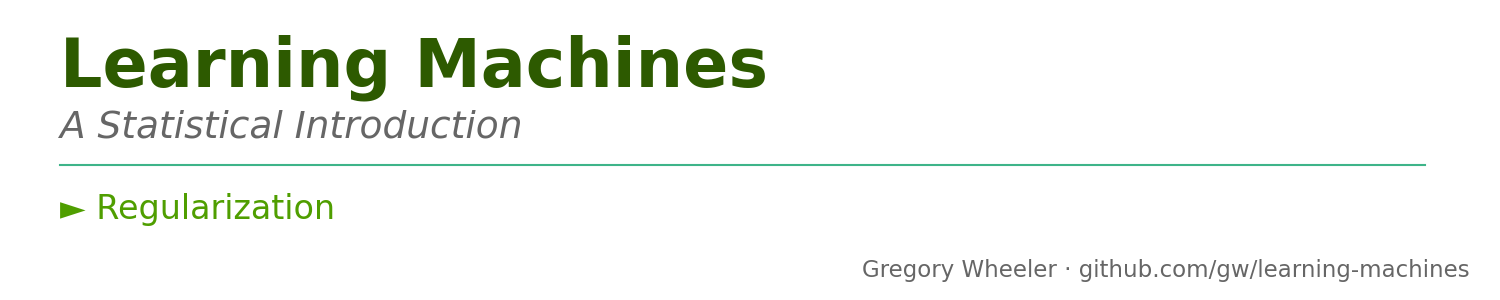
</div>


# Chapter 7: Regularization

This notebook accompanies **Chapter 7** of *Machine Learning: A Statistical Introduction*.

We explore techniques to prevent overfitting by constraining model complexity:
- The problem of overfitting in high dimensions
- Ridge regression (L2 regularization)
- LASSO regression (L1 regularization)
- Choosing the regularization strength
- Geometric interpretation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon
from matplotlib.colors import LogNorm
import sys
from pathlib import Path

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

# For reproducibility
np.random.seed(42)

---
## 1. The Overfitting Problem Revisited

Recall from Chapter 5: complex models can **overfit** by fitting noise in the training data.

**Regularization** adds a penalty term to discourage overly complex models:

$$\text{Regularized Cost} = \text{Loss}(\text{data}, \theta) + \lambda \cdot \text{Penalty}(\theta)$$

where $\lambda$ controls the strength of regularization.

In [ ]:
# Generate polynomial regression data
def true_function(x):
    return np.sin(2 * np.pi * x)

def generate_data(n_samples, noise_std=0.3, seed=42):
    np.random.seed(seed)
    x = np.random.uniform(0, 1, n_samples)
    y = true_function(x) + np.random.normal(0, noise_std, n_samples)
    return x, y

# Small dataset prone to overfitting
x_train, y_train = generate_data(15, noise_std=0.3, seed=42)
x_test = np.linspace(0, 1, 100)
y_test_true = true_function(x_test)

In [ ]:
def create_polynomial_features(x, degree):
    """Create polynomial feature matrix [1, x, x², ..., x^degree]."""
    X = np.column_stack([x**d for d in range(degree + 1)])
    return X

def fit_ols(X, y):
    """Ordinary least squares (no regularization)."""
    return np.linalg.lstsq(X, y, rcond=None)[0]

# Show overfitting with high-degree polynomial
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x_train, y_train, c=mt.GREEN, s=100, edgecolors='white', 
           linewidths=2, zorder=5, label='Training data')
ax.plot(x_test, y_test_true, c=mt.GRAY, linewidth=2, linestyle='--', label='True function')

# Fit degree-12 polynomial (overfit)
X_train = create_polynomial_features(x_train, 12)
X_test = create_polynomial_features(x_test, 12)
theta_ols = fit_ols(X_train, y_train)
y_pred_ols = X_test @ theta_ols

ax.plot(x_test, y_pred_ols, c=mt.RED, linewidth=2.5, label='Degree-12 polynomial (OLS)')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Overfitting: High-Degree Polynomial without Regularization', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_xlim(0, 1)
ax.set_ylim(-2, 2)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

print(f"Coefficient magnitudes (OLS): {np.abs(theta_ols).max():.1f}")

Notice the **huge coefficient magnitudes** — a telltale sign of overfitting.

---
## 2. Ridge Regression (L2 Regularization)

**Ridge regression** adds an L2 penalty on the coefficients:

$$J_{\text{ridge}}(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}\theta_j^2$$

The closed-form solution is:

$$\theta_{\text{ridge}} = (X^TX + \lambda I)^{-1}X^Ty$$

where we typically don't penalize the intercept term $\theta_0$.

In [ ]:
def fit_ridge(X, y, lambda_):
    """
    Fit Ridge regression.
    
    Parameters
    ----------
    X : ndarray of shape (m, n)
        Feature matrix (with intercept column)
    y : ndarray of shape (m,)
        Target values
    lambda_ : float
        Regularization strength
    
    Returns
    -------
    theta : ndarray of shape (n,)
        Fitted coefficients
    """
    m, n = X.shape
    
    # Don't penalize the intercept (first column)
    penalty = lambda_ * np.eye(n)
    penalty[0, 0] = 0  # No penalty on intercept
    
    theta = np.linalg.solve(X.T @ X + penalty, X.T @ y)
    return theta

In [ ]:
# Compare OLS vs Ridge for different lambda values
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

lambdas = [0, 0.001, 0.1, 10]

for ax, lam in zip(axes, lambdas):
    theta = fit_ridge(X_train, y_train, lam)
    y_pred = X_test @ theta
    
    ax.scatter(x_train, y_train, c=mt.GREEN, s=60, edgecolors='white', 
               linewidths=1.5, zorder=5)
    ax.plot(x_test, y_test_true, c=mt.GRAY, linewidth=2, linestyle='--')
    ax.plot(x_test, y_pred, c=mt.BLUE, linewidth=2.5)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    title = 'OLS (no reg.)' if lam == 0 else f'Ridge (λ={lam})'
    ax.set_title(f"{title}\nmax|θ|={np.abs(theta).max():.1f}", fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 2)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Effect of increasing λ:**
- Small λ: Nearly identical to OLS (overfitting persists)
- Moderate λ: Smoother curve, reduced overfitting
- Large λ: Too smooth, underfitting (high bias)

---
## 3. Coefficient Paths: Ridge

A **coefficient path** shows how each coefficient changes as we vary λ.

In [ ]:
# Compute coefficient path for Ridge
lambdas_path = np.logspace(-4, 4, 100)
ridge_coefs = []

for lam in lambdas_path:
    theta = fit_ridge(X_train, y_train, lam)
    ridge_coefs.append(theta[1:])  # Exclude intercept

ridge_coefs = np.array(ridge_coefs)

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(ridge_coefs.shape[1]):
    ax.plot(lambdas_path, ridge_coefs[:, i], linewidth=1.5, alpha=0.8)

ax.set_xscale('log')
ax.axhline(y=0, color=mt.GRAY, linestyle='--', alpha=0.5)
ax.set_xlabel('λ (regularization strength)')
ax.set_ylabel('Coefficient value')
ax.set_title('Ridge Coefficient Paths', fontweight='bold', loc='left')

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

**Key observation:** Ridge regression **shrinks coefficients toward zero** but never exactly to zero. All features remain in the model.

---
## 4. LASSO Regression (L1 Regularization)

**LASSO** (Least Absolute Shrinkage and Selection Operator) uses an L1 penalty:

$$J_{\text{lasso}}(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}|\theta_j|$$

Unlike Ridge, LASSO can produce **exactly zero coefficients**, performing feature selection.

In [ ]:
def fit_lasso(X, y, lambda_, max_iter=10000, tol=1e-6):
    """
    Fit LASSO regression using coordinate descent.
    
    Parameters
    ----------
    X : ndarray of shape (m, n)
        Feature matrix (with intercept column)
    y : ndarray of shape (m,)
        Target values
    lambda_ : float
        Regularization strength
    
    Returns
    -------
    theta : ndarray of shape (n,)
        Fitted coefficients
    """
    m, n = X.shape
    theta = np.zeros(n)
    
    # Precompute X^T X diagonal and X^T y
    X_sq = np.sum(X**2, axis=0)
    
    for iteration in range(max_iter):
        theta_old = theta.copy()
        
        for j in range(n):
            # Compute residual without feature j
            residual = y - X @ theta + X[:, j] * theta[j]
            rho = X[:, j] @ residual
            
            if j == 0:  # Don't regularize intercept
                theta[j] = rho / X_sq[j] if X_sq[j] > 0 else 0
            else:
                # Soft thresholding
                if rho < -lambda_ * m:
                    theta[j] = (rho + lambda_ * m) / X_sq[j]
                elif rho > lambda_ * m:
                    theta[j] = (rho - lambda_ * m) / X_sq[j]
                else:
                    theta[j] = 0
        
        # Check convergence
        if np.max(np.abs(theta - theta_old)) < tol:
            break
    
    return theta

In [ ]:
# Compare Ridge vs LASSO
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

lambdas = [0.0001, 0.001, 0.01, 0.1]

for col, lam in enumerate(lambdas):
    # Ridge
    ax = axes[0, col]
    theta_ridge = fit_ridge(X_train, y_train, lam)
    y_pred_ridge = X_test @ theta_ridge
    n_nonzero_ridge = np.sum(np.abs(theta_ridge[1:]) > 1e-6)
    
    ax.scatter(x_train, y_train, c=mt.GREEN, s=50, edgecolors='white', linewidths=1, zorder=5)
    ax.plot(x_test, y_test_true, c=mt.GRAY, linewidth=1.5, linestyle='--')
    ax.plot(x_test, y_pred_ridge, c=mt.BLUE, linewidth=2.5)
    ax.set_title(f'Ridge λ={lam}\n({n_nonzero_ridge} nonzero)', fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 2)
    if col == 0:
        ax.set_ylabel('Ridge', fontsize=12, fontweight='bold')
    mt.apply_economist_style(ax)
    
    # LASSO
    ax = axes[1, col]
    theta_lasso = fit_lasso(X_train, y_train, lam)
    y_pred_lasso = X_test @ theta_lasso
    n_nonzero_lasso = np.sum(np.abs(theta_lasso[1:]) > 1e-6)
    
    ax.scatter(x_train, y_train, c=mt.GREEN, s=50, edgecolors='white', linewidths=1, zorder=5)
    ax.plot(x_test, y_test_true, c=mt.GRAY, linewidth=1.5, linestyle='--')
    ax.plot(x_test, y_pred_lasso, c=mt.RED, linewidth=2.5)
    ax.set_title(f'LASSO λ={lam}\n({n_nonzero_lasso} nonzero)', fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 2)
    ax.set_xlabel('x')
    if col == 0:
        ax.set_ylabel('LASSO', fontsize=12, fontweight='bold')
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Key difference:** LASSO produces **sparse solutions** — many coefficients become exactly zero, effectively removing features from the model.

---
## 5. Coefficient Paths: LASSO

The LASSO path shows coefficients dropping to exactly zero.

In [ ]:
# Compute coefficient path for LASSO
lambdas_lasso = np.logspace(-5, 0, 50)
lasso_coefs = []

for lam in lambdas_lasso:
    theta = fit_lasso(X_train, y_train, lam)
    lasso_coefs.append(theta[1:])  # Exclude intercept

lasso_coefs = np.array(lasso_coefs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ridge path
ax = axes[0]
for i in range(ridge_coefs.shape[1]):
    ax.plot(lambdas_path, ridge_coefs[:, i], linewidth=1.5, alpha=0.8)
ax.set_xscale('log')
ax.axhline(y=0, color=mt.GRAY, linestyle='--', alpha=0.5)
ax.set_xlabel('λ')
ax.set_ylabel('Coefficient value')
ax.set_title('Ridge: Coefficients shrink but stay nonzero', fontweight='bold', loc='left')
mt.apply_economist_style(ax)

# LASSO path
ax = axes[1]
for i in range(lasso_coefs.shape[1]):
    ax.plot(lambdas_lasso, lasso_coefs[:, i], linewidth=1.5, alpha=0.8)
ax.set_xscale('log')
ax.axhline(y=0, color=mt.GRAY, linestyle='--', alpha=0.5)
ax.set_xlabel('λ')
ax.set_ylabel('Coefficient value')
ax.set_title('LASSO: Coefficients become exactly zero', fontweight='bold', loc='left')
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

---
## 6. Geometric Interpretation

The difference between Ridge and LASSO can be understood geometrically:

- **Ridge**: Constraint region is a **circle** (or hypersphere) → solutions on the boundary rarely hit axes
- **LASSO**: Constraint region is a **diamond** (or cross-polytope) → corners lie on axes, so solutions often have zero coefficients

In [ ]:
# Geometric interpretation
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

# Create contours of loss function
theta1 = np.linspace(-3, 3, 200)
theta2 = np.linspace(-3, 3, 200)
T1, T2 = np.meshgrid(theta1, theta2)

# Elliptical contours (representing squared loss)
# Centered at OLS solution (e.g., [1.5, 2])
ols_solution = np.array([1.5, 2.0])
Loss = 0.5 * ((T1 - ols_solution[0])**2 + 0.3*(T2 - ols_solution[1])**2)

# Ridge constraint (L2 ball)
ax = axes[0]
ax.contour(T1, T2, Loss, levels=15, colors=mt.BLUE, alpha=0.6)

# L2 ball
circle = Circle((0, 0), 1.3, fill=False, edgecolor=mt.RED, linewidth=3)
ax.add_patch(circle)

# Mark OLS solution
ax.scatter(*ols_solution, c=mt.BLUE, s=150, zorder=5, marker='*', 
           edgecolors='white', linewidths=1.5, label='OLS solution')

# Mark Ridge solution (approximately where contour touches circle)
ridge_sol = np.array([0.75, 1.05])
ax.scatter(*ridge_sol, c=mt.RED, s=150, zorder=5, marker='o',
           edgecolors='white', linewidths=2, label='Ridge solution')

ax.axhline(y=0, color=mt.GRAY, linestyle='-', alpha=0.3)
ax.axvline(x=0, color=mt.GRAY, linestyle='-', alpha=0.3)
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_title('Ridge (L2): Circular constraint', fontweight='bold')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.legend(loc='upper right')

# LASSO constraint (L1 diamond)
ax = axes[1]
ax.contour(T1, T2, Loss, levels=15, colors=mt.BLUE, alpha=0.6)

# L1 diamond
r = 1.3
diamond = Polygon([(r, 0), (0, r), (-r, 0), (0, -r)], 
                  fill=False, edgecolor=mt.RED, linewidth=3)
ax.add_patch(diamond)

# Mark OLS solution
ax.scatter(*ols_solution, c=mt.BLUE, s=150, zorder=5, marker='*',
           edgecolors='white', linewidths=1.5, label='OLS solution')

# Mark LASSO solution (at a corner - sparse!)
lasso_sol = np.array([0, 1.3])  # θ₁ = 0 (sparse!)
ax.scatter(*lasso_sol, c=mt.RED, s=150, zorder=5, marker='o',
           edgecolors='white', linewidths=2, label='LASSO solution')

ax.axhline(y=0, color=mt.GRAY, linestyle='-', alpha=0.3)
ax.axvline(x=0, color=mt.GRAY, linestyle='-', alpha=0.3)
ax.set_xlabel(r'$\theta_1$', fontsize=14)
ax.set_ylabel(r'$\theta_2$', fontsize=14)
ax.set_title('LASSO (L1): Diamond constraint → sparse solution', fontweight='bold')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

**Why LASSO produces zeros:**
- The elliptical loss contours often first touch the diamond at a **corner**
- Corners lie on coordinate axes, meaning some $\theta_j = 0$
- The circle (Ridge) has no corners, so contours touch the boundary away from axes

---
## 7. Choosing λ with Cross-Validation

The regularization strength λ is a **hyperparameter** that must be chosen. We use cross-validation.

In [ ]:
def cross_val_mse(X, y, fit_fn, lambda_, k=5):
    """Compute K-fold CV MSE for a given lambda."""
    n = len(y)
    indices = np.random.permutation(n)
    fold_size = n // k
    
    mses = []
    for i in range(k):
        val_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
        
        X_train_cv, y_train_cv = X[train_idx], y[train_idx]
        X_val_cv, y_val_cv = X[val_idx], y[val_idx]
        
        theta = fit_fn(X_train_cv, y_train_cv, lambda_)
        y_pred = X_val_cv @ theta
        mse = np.mean((y_val_cv - y_pred)**2)
        mses.append(mse)
    
    return np.mean(mses), np.std(mses)

In [ ]:
# Generate more data for meaningful CV
np.random.seed(42)
x_full, y_full = generate_data(100, noise_std=0.3)
X_full = create_polynomial_features(x_full, 10)

# Evaluate Ridge across lambda values
lambdas_cv = np.logspace(-4, 2, 30)
ridge_cv_scores = []
ridge_cv_stds = []

for lam in lambdas_cv:
    mean_mse, std_mse = cross_val_mse(X_full, y_full, fit_ridge, lam)
    ridge_cv_scores.append(mean_mse)
    ridge_cv_stds.append(std_mse)

ridge_cv_scores = np.array(ridge_cv_scores)
ridge_cv_stds = np.array(ridge_cv_stds)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(lambdas_cv, ridge_cv_scores, 'o-', c=mt.GREEN, linewidth=2, markersize=6)
ax.fill_between(lambdas_cv, 
                ridge_cv_scores - ridge_cv_stds, 
                ridge_cv_scores + ridge_cv_stds,
                alpha=0.2, color=mt.GREEN)

# Mark optimal
best_idx = np.argmin(ridge_cv_scores)
ax.axvline(x=lambdas_cv[best_idx], color=mt.RED, linestyle='--', linewidth=2,
           label=f'Optimal λ = {lambdas_cv[best_idx]:.4f}')

ax.set_xscale('log')
ax.set_xlabel('λ (regularization strength)')
ax.set_ylabel('Cross-Validation MSE')
ax.set_title('Choosing λ via Cross-Validation', fontweight='bold', loc='left')
ax.legend()

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

print(f"Optimal λ: {lambdas_cv[best_idx]:.4f}")
print(f"Best CV MSE: {ridge_cv_scores[best_idx]:.4f}")

---
## 8. Standardization

**Important:** Regularization penalizes large coefficients. If features have different scales, features with larger values will be penalized more.

**Always standardize features before applying regularization:**

$$x_j^{\text{std}} = \frac{x_j - \mu_j}{\sigma_j}$$

In [ ]:
def standardize(X):
    """Standardize features (except intercept column)."""
    X_std = X.copy()
    # Don't standardize intercept (column 0)
    means = X_std[:, 1:].mean(axis=0)
    stds = X_std[:, 1:].std(axis=0) + 1e-10
    X_std[:, 1:] = (X_std[:, 1:] - means) / stds
    return X_std, means, stds

# Demonstrate effect of standardization
np.random.seed(42)

# Create features with very different scales
n = 50
X_unscaled = np.column_stack([
    np.ones(n),
    np.random.randn(n) * 0.01,     # Tiny scale
    np.random.randn(n) * 1000,     # Huge scale
])
y_demo = X_unscaled[:, 1] * 100 + X_unscaled[:, 2] * 0.001 + np.random.randn(n) * 0.1

# Fit without standardization
theta_no_std = fit_ridge(X_unscaled, y_demo, lambda_=1.0)

# Fit with standardization
X_standardized, _, _ = standardize(X_unscaled)
theta_std = fit_ridge(X_standardized, y_demo, lambda_=1.0)

print("Without standardization:")
print(f"  θ₁ (tiny scale feature): {theta_no_std[1]:.4f}")
print(f"  θ₂ (huge scale feature): {theta_no_std[2]:.6f}")
print(f"\nWith standardization:")
print(f"  θ₁: {theta_std[1]:.4f}")
print(f"  θ₂: {theta_std[2]:.4f}")

---
## 9. Ridge vs LASSO: When to Use Which?

| Aspect | Ridge | LASSO |
|--------|-------|-------|
| Penalty | $\sum \theta_j^2$ (L2) | $\sum |\theta_j|$ (L1) |
| Sparsity | No (all features kept) | Yes (feature selection) |
| Correlated features | Keeps all, shrinks together | Arbitrarily picks one |
| Computation | Closed form | Iterative (coordinate descent) |
| Use when | Many small effects | Few large effects, need interpretability |

In [ ]:
# Compare sparsity
fig, ax = plt.subplots(figsize=(10, 5))

lambdas_compare = np.logspace(-4, 0, 30)

ridge_nonzero = []
lasso_nonzero = []

for lam in lambdas_compare:
    theta_r = fit_ridge(X_full, y_full, lam)
    theta_l = fit_lasso(X_full, y_full, lam)
    
    ridge_nonzero.append(np.sum(np.abs(theta_r[1:]) > 1e-6))
    lasso_nonzero.append(np.sum(np.abs(theta_l[1:]) > 1e-6))

ax.plot(lambdas_compare, ridge_nonzero, 'o-', c=mt.BLUE, linewidth=2, 
        markersize=6, label='Ridge')
ax.plot(lambdas_compare, lasso_nonzero, 's-', c=mt.RED, linewidth=2,
        markersize=6, label='LASSO')

ax.set_xscale('log')
ax.set_xlabel('λ')
ax.set_ylabel('Number of nonzero coefficients')
ax.set_title('Sparsity: Ridge vs LASSO', fontweight='bold', loc='left')
ax.legend()
ax.set_ylim(0, 12)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

## 10. Elastic Net: Combining L1 and L2

**Elastic Net** combines both penalties:

$$J_{\text{elastic}}(\theta) = \text{Loss} + \alpha \cdot \rho \sum|\theta_j| + \alpha \cdot (1-\rho) \sum\theta_j^2$$

where $\alpha$ controls overall regularization strength and $\rho \in [0,1]$ controls the L1/L2 mix:
- $\rho = 1$: Pure LASSO
- $\rho = 0$: Pure Ridge  
- $\rho = 0.5$: Equal mix

This gets the feature selection of LASSO while handling correlated features like Ridge.

In [ ]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso

# Standardize features for fair comparison
X_std, _, _ = standardize(X_full)

# Compare coefficient paths for all three methods
alphas = np.logspace(-2, 2, 50)
l1_ratio = 0.5  # Equal mix of L1 and L2

ridge_coefs = []
lasso_coefs = []
elastic_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_std, y_full)
    lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_std, y_full)
    elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000).fit(X_std, y_full)
    
    ridge_coefs.append(ridge.coef_)
    lasso_coefs.append(lasso.coef_)
    elastic_coefs.append(elastic.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)
elastic_coefs = np.array(elastic_coefs)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Ridge paths
ax = axes[0]
for j in range(ridge_coefs.shape[1]):
    ax.plot(np.log10(alphas), ridge_coefs[:, j], linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('log(α)')
ax.set_ylabel('Coefficient')
ax.set_title('Ridge (L2)', fontsize=12, loc='left')
mt.apply_economist_style(ax)

# LASSO paths
ax = axes[1]
for j in range(lasso_coefs.shape[1]):
    ax.plot(np.log10(alphas), lasso_coefs[:, j], linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('log(α)')
ax.set_title('LASSO (L1)', fontsize=12, loc='left')
mt.apply_economist_style(ax)

# Elastic Net paths
ax = axes[2]
for j in range(elastic_coefs.shape[1]):
    ax.plot(np.log10(alphas), elastic_coefs[:, j], linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('log(α)')
ax.set_title('Elastic Net (ρ=0.5)', fontsize=12, loc='left')
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

Elastic Net inherits properties from both:
- Like LASSO, some coefficients shrink to exactly zero (sparse selection)
- Like Ridge, correlated features tend to have similar coefficients

In practice, Elastic Net often works better than pure LASSO when predictors are correlated, which is common in real datasets.

---
## Summary

**Regularization** prevents overfitting by penalizing model complexity:

| Method | Penalty | Key Property |
|--------|---------|---------------|
| Ridge (L2) | $\lambda\sum\theta_j^2$ | Shrinks all coefficients |
| LASSO (L1) | $\lambda\sum|\theta_j|$ | Produces sparse solutions |
| Elastic Net | Both | Best of both worlds |

**Key takeaways:**
- Regularization trades off bias for reduced variance
- Choose λ via cross-validation
- Always standardize features first
- LASSO for feature selection, Ridge when all features contribute

**Next steps** (covered in the book):
- Regularization in logistic regression
- Tree-based methods (which have different regularization approaches)